In [1]:
import numpy as np
import matplotlib.pyplot as plt
import string
import codecs
import re
import os.path
from spellchecker import SpellChecker
import snowballstemmer
import unicodedata
from sklearn.feature_extraction.text import CountVectorizer,TfidfVectorizer
from nltk.corpus import stopwords
from wordcloud import WordCloud
from sklearn import svm 
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import train_test_split
from sklearn.model_selection import cross_val_score
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score
from sklearn.naive_bayes import MultinomialNB
from sklearn.metrics import roc_curve, auc, f1_score, confusion_matrix , make_scorer
from sklearn.neural_network import MLPClassifier
from tqdm import tqdm
from sklearn.decomposition import TruncatedSVD
from sklearn.manifold import TSNE
import json
from collections import Counter
import warnings
warnings.filterwarnings("ignore")
from imblearn.over_sampling import SMOTE
from sklearn.svm import SVC
from sklearn.svm import LinearSVC



# Données reconnaissance du locuteur (Chirac/Mitterrand)

In [6]:
# Chargement des données:
def load_pres(fname):
    alltxts = []
    alllabs = []
    s=codecs.open(fname, 'r','utf-8') # pour régler le codage
    while True:
        txt = s.readline()
        if(len(txt))<5:
            break
        #
        lab = re.sub(r"<[0-9]*:[0-9]*:(.)>.*","\\1",txt)
        txt = re.sub(r"<[0-9]*:[0-9]*:.>(.*)","\\1",txt)
        if lab.count('M') >0:
            alllabs.append(-1)
        else: 
            alllabs.append(1)
        alltxts.append(txt)
    return np.array(alltxts),np.array(alllabs)

def create_output_file(y_pred,name):
    with open("test_eval_movies_with_large_dataset"+name+".txt",'w') as f:
        for y in y_pred:
            if y == -1:
                f.write("M")
                f.write("\n")
            else:
                f.write("C")
                f.write("\n")



def get_stats(label):
    
    [clpos,claneg],[nbpos,nbneg] = np.unique(label,return_counts=True)
    print("Nombre de documents classés positifs ",nbpos)
    print("Nombre de documents classés négatifs ",nbneg)
    
    plt.title("Distribution des classes sur les documents")
    plt.hist(label)
    
# les poids relatifs au metriques de base
w_accuracy = 0.1
w_f1score = 0.6
w_auc = 0.3

def metrique_globale(ytest,ypred):
    accuracy = accuracy_score(ytest,ypred)
    fpr, tpr, thresholds = roc_curve(y_test,y_scores)
    roc_auc = auc(fpr, tpr)
    f1_score = precision_recall_fscore_support(y_true, y_pred)[2]
    return w_accuracyaccuracy + w_f1scoref1score + w_auc*roc_auc

# Affichage du nuage de points de notre base
def get_nuage_points(vectors,alllabs):
    svd = TruncatedSVD(n_components=2, n_iter=7, random_state=42)
    U = svd.fit_transform(vectors)
    V = svd.components_

    tsne = TSNE(n_components=2, init='pca',n_iter=5000, verbose=0)
    tsne_mat = tsne.fit_transform(U)
    NN2cluster = np.argmax(np.abs(U), axis=0)

    plt.figure(figsize=(15,10))
    plt.scatter(tsne_mat[:,0],tsne_mat[:,1],c=alllabs, s=10)
    
def supp_punc(chaine) : 
    punc = string.punctuation  
    punc += '\n\r\t'
    chaine = chaine.translate(str.maketrans(punc, ' ' * len(punc))) 
    return chaine
def supp_punc_chiffre(chaine) : 
    chaine = supp_punc(chaine)
    chaine = re.sub('[0-9]',"", chaine)
    return chaine
def filtred_stop_word(liste) : 
    stopWord = stopwords.words('french') + stopwords.words('english')
    res = []
    for word,cpt in liste:
        if word not in stopWord :
            res.append(word + " ")
    return res

def get_number_sentences(texte):
    splited_text = texte.split('.')
    count = len(splited_text)
    number_sentences = int(count * 0.3)
    text1 = splited_text[:number_sentences]
    text2 = splited_text[-number_sentences:]
    return ''.join(map(str,text1)) + ''.join(map(str,text2))


def preprocess_strat1(text):
    # un mot syntaxiquement correcte 
    text = supp_punc_chiffre(text)
    text = unicodedata.normalize('NFD', text).encode('ascii', 'ignore').decode("utf-8")
    text = text.lower()
    return text.replace("."," ") 
def preprocess_strat2(text) :
    default_word = '<MOT_EN_MAJUSCULES>'
    text = supp_punc_chiffre(text)
    text = unicodedata.normalize('NFD', text).encode('ascii', 'ignore').decode("utf-8")
    text = re.sub(r'\b[A-Z]+\b',default_word, text)
    return text
def preprocess_strat3(text):
    default_word = '<MOT_EN_MAJUSCULES>'
    text = supp_punc(text)
    text = unicodedata.normalize('NFD', text).encode('ascii', 'ignore').decode("utf-8")
    text = re.sub(r'\b[A-Z]+\b',default_word, text)
    return text
 
def preprocess_strat4(text) : 
    text = supp_punc_chiffre(text)
    text = unicodedata.normalize('NFD', text).encode('ascii', 'ignore').decode("utf-8")
    return text

def preprocess_strat5(text):
    text = supp_punc_chiffre(text)
    text = get_number_sentences(text)
    return text

def preprocess_strat6(text) : 
    default_word = '<MOT_EN_MAJUSCULES>'
    text = supp_punc_chiffre(text)
    text = get_number_sentences(text)
    text = re.sub(r'\b[A-Z]+\b',default_word, text)
    return text

def database_stemming(data):
    data_stemmer = []
    stemmer = snowballstemmer.stemmer("english")
    for doc in tqdm(data):
        chaine = ""
        for word in doc.split(" "):
            chaine += stemmer.stemWord(word)+" "
        data_stemmer.append(chaine)
    return data_stemmer

def affiche_matrice_conf(y_true,y_pred):
    conf_matrix = confusion_matrix(y_true, y_pred)

    plt.imshow(conf_matrix, cmap='binary', interpolation='None')
    plt.colorbar()
    plt.xticks([0, 1], ['0', '1'])
    plt.yticks([0, 1], ['0', '1'])
    plt.xlabel('Prédictions')
    plt.ylabel('Vraies valeurs')
    plt.show()

Nombre de documents classés positifs  7523
Nombre de documents classés négatifs  49890


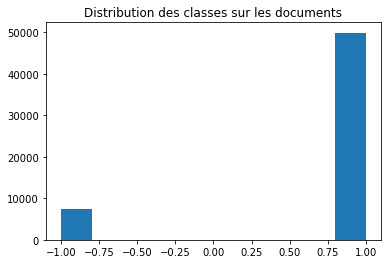

In [4]:
fname = "./datasets/AFDpresidentutf8/corpus.tache1.learn.utf8"
data_large,label_large = load_pres(fname)
get_stats(label_large)

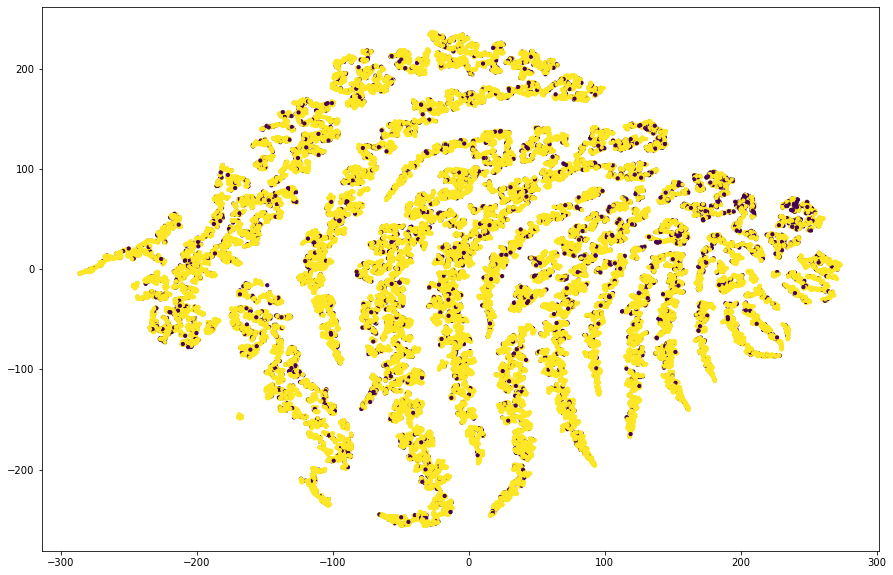

In [7]:
vectorizer = CountVectorizer()
vectors = vectorizer.fit_transform(data_large)
get_nuage_points(vectors,label_large)

# A) Transformation paramétrique du texte (pre-traitements)

Vous devez tester, par exemple, les cas suivants:
- transformation en minuscule ou pas
- suppression de la ponctuation
- transformation des mots entièrement en majuscule en marqueurs spécifiques
- suppression des chiffres ou pas
- conservation d'une partie du texte seulement (seulement la première ligne = titre, seulement la dernière ligne = résumé, ...)
- stemming
- ...


Vérifier systématiquement sur un exemple ou deux le bon fonctionnement des méthodes sur deux documents (au moins un de chaque classe).

## Fonctions Utiles

In [6]:
liste_preprocess = [preprocess_strat1,preprocess_strat2,preprocess_strat3,preprocess_strat4,preprocess_strat5]
doc_classe_1 = data_large[label_large==-1][0]
doc_classe_2 = data_large[label_large==1][0]
print("le document 1 avant toute modification :\n\n",doc_classe_1)
for i in range(len(liste_preprocess)) : 
    print("------------------- PREPROCESS STRAT" + str(i+1) + "-----------------------")
    print(liste_preprocess[i](doc_classe_1))
    print("----------------------------------------------------------------------------")

le document 1 avant toute modification :

  Je ne sais ni pourquoi ni comment on s'est opposé il y a quelques douze années - douze ou treize ans - à la création de l'Université technologique.

------------------- PREPROCESS STRAT1-----------------------
 je ne sais ni pourquoi ni comment on s est oppose il y a quelques douze annees   douze ou treize ans   a la creation de l universite technologique  
----------------------------------------------------------------------------
------------------- PREPROCESS STRAT2-----------------------
 Je ne sais ni pourquoi ni comment on s est oppose il y a quelques douze annees   douze ou treize ans   a la creation de l Universite technologique  
----------------------------------------------------------------------------
------------------- PREPROCESS STRAT3-----------------------
 Je ne sais ni pourquoi ni comment on s est oppose il y a quelques douze annees   douze ou treize ans   a la creation de l Universite technologique  
--------------------

In [7]:
print("le document 2 avant toute modification :\n\n",doc_classe_2)
for i in range(len(liste_preprocess)) : 
    print("------------------- PREPROCESS STRAT" + str(i+1) + "-----------------------")
    print(liste_preprocess[i](doc_classe_2))
    print("----------------------------------------------------------------------------")

le document 2 avant toute modification :

  Quand je dis chers amis, il ne s'agit pas là d'une formule diplomatique, mais de l'expression de ce que je ressens.

------------------- PREPROCESS STRAT1-----------------------
 quand je dis chers amis  il ne s agit pas la d une formule diplomatique  mais de l expression de ce que je ressens  
----------------------------------------------------------------------------
------------------- PREPROCESS STRAT2-----------------------
 Quand je dis chers amis  il ne s agit pas la d une formule diplomatique  mais de l expression de ce que je ressens  
----------------------------------------------------------------------------
------------------- PREPROCESS STRAT3-----------------------
 Quand je dis chers amis  il ne s agit pas la d une formule diplomatique  mais de l expression de ce que je ressens  
----------------------------------------------------------------------------
------------------- PREPROCESS STRAT4-----------------------
 Quand je 

# B) Extraction du vocabulaire (BoW)

- **Exploration préliminaire des jeux de données**
    - Quelle est la taille d'origine du vocabulaire?
    - Que reste-t-il si on ne garde que les 100 mots les plus fréquents? [word cloud]
    - Quels sont les 100 mots dont la fréquence documentaire est la plus grande? [word cloud]
    - Quels sont les 100 mots les plus discriminants au sens de odds ratio? [word cloud]
    - Quelle est la distribution d'apparition des mots (Zipf)
    - Quels sont les 100 bigrammes/trigrammes les plus fréquents?

- **Variantes de BoW**
    - TF-IDF
    - Réduire la taille du vocabulaire (min_df, max_df, max_features)
    - BoW binaire
    - Bi-grams, tri-grams
    - **Quelles performances attendrent? Quels sont les avantages et les inconvénients des ces variantes?**

In [8]:
final_stopwords_list = stopwords.words('english') + stopwords.words('french')

## 100 Mots

###  les plus frequent dans chaque document

In [9]:
#Garder les 100 mots les plus frequent dans chaque document ( en enlevant la ponctuation et les stops words)
def get_mots_frequent_par_doc(alltxts):
    corpus = []
    punc = string.punctuation
    for doc in alltxts :
        vocab = dict()
        doc = doc.translate(str.maketrans(punc, " "* len(punc)))
        for word in doc.split() : 
            if word in vocab.keys(): 
                vocab[word] += 1
            else : 
                vocab[word]=1
        #100 mots les plus frequent 
        l = sorted(vocab.items(),key = lambda x : x[1],reverse=True)
        l = filtred_stop_word(l)[: 100]
        chaine = ""
        for word in l :
            chaine += word+ " "  
        corpus.append(chaine)
    return corpus

la taille du vocabulaire si on ne garde que les 100 mots les plus fréquents est :  28448


(-0.5, 399.5, 199.5, -0.5)

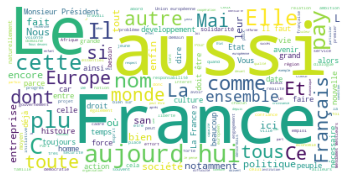

In [10]:
corpus = get_mots_frequent_par_doc(data_large)
corpus_word = "".join(corpus)
vectorize = CountVectorizer()
X_freq = vectorize.fit_transform(corpus)
print("la taille du vocabulaire si on ne garde que les 100 mots les plus fréquents est : " ,len(vectorize.get_feature_names_out()))
#print(corpus)
wordcoud = WordCloud(background_color = "white").generate(corpus_word)

plt.figure()
plt.imshow(wordcoud)
plt.axis("off")

### Frequences documentaire

les 100 mots les plus frequents dans le documents sont :
 ['de' 'la' 'et' 'le' 'les' 'est' 'des' 'en' 'que' 'qui' 'une' 'un' 'pour'
 'dans' 'nous' 'il' 'je' 'vous' 'du' 'ce' 'plus' 'au' 'pas' 'notre' 'qu'
 'france' 'ne' 'elle' 'nos' 'par' 'sur' 'cette' 'sont' 'aussi' 'avec'
 'mais' 'pays' 'se' 'être' 'ont' 'aux' 'leur' 'votre' 'nom' 'tout' 'tous'
 'son' 'doit' 'bien' 'europe' 'on' 'ces' 'même' 'ses' 'hui' 'aujourd'
 'entre' 'sa' 'faut' 'faire' 'comme' 'ils' 'français' 'monde' 'ai' 'ou'
 'cela' 'fait' 'été' 'sans' 'si' 'monsieur' 'date' 'avez' 'ensemble'
 'président' 'deux' 'leurs' 'très' 'peut' 'avons' 'développement'
 'politique' 'où' 'dire' 'vos' 'encore' 'autres' 'avenir' 'temps' 'abord'
 'toutes' 'paix' 'vie' 'dont' 'messieurs' 'chacun' 'depuis' 'beaucoup'
 'etat']


(-0.5, 399.5, 199.5, -0.5)

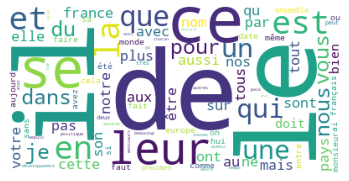

In [11]:
vectorizer = TfidfVectorizer()
X_freq_doc = vectorizer.fit_transform(data_large)
freq = X_freq_doc.sum(axis=0).A1
indice_100 = np.argsort(-freq)[:100]
mots_freq = np.array(vectorizer.get_feature_names_out())[indice_100]
print("les 100 mots les plus frequents dans le documents sont :\n", mots_freq)

corpus_100_freq =""
for mots in mots_freq : 
    corpus_100_freq += mots+" "
wordcoud_freq = WordCloud(background_color = "white",stopwords="").generate(corpus_100_freq)
plt.figure()
plt.imshow(wordcoud_freq)
plt.axis("off")

***Bien évidemment, les 100 mots les plus fréquents sont des stop words***

### Sans Stop words

les 100 mots les plus frequents dans le documents sont :
 ['plus' 'france' 'cette' 'aussi' 'pays' 'être' 'nom' 'tout' 'tous' 'bien'
 'doit' 'europe' 'hui' 'aujourd' 'entre' 'faire' 'faut' 'comme' 'français'
 'monde' 'fait' 'cela' 'sans' 'si' 'monsieur' 'date' 'président'
 'ensemble' 'deux' 'très' 'peut' 'leurs' 'dire' 'développement' 'où'
 'politique' 'autres' 'encore' 'avenir' 'temps' 'abord' 'paix' 'toutes'
 'vie' 'dont' 'chacun' 'beaucoup' 'etat' 'depuis' 'messieurs' 'toute'
 'ici' 'union' 'devons' 'elles' 'ceux' 'européenne' 'sécurité' 'là'
 'toujours' 'histoire' 'mesdames' 'ans' 'économique' 'enfin' 'société'
 'premier' 'place' 'grande' 'confiance' 'cet' 'action' 'entreprises'
 'grand' 'doivent' 'notamment' 'solidarité' 'mieux' 'parce' 'autre'
 'démocratie' 'volonté' 'droit' 'contre' 'ainsi' 'chaque' 'dialogue'
 'coeur' 'progrès' 'respect' 'liberté' 'déjà' 'fois' 'également' 'travail'
 'jeunes' 'république' 'service' 'donc' 'hommes']


(-0.5, 399.5, 199.5, -0.5)

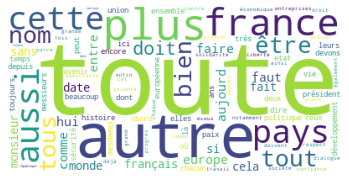

In [12]:
vectorizer = TfidfVectorizer(stop_words=final_stopwords_list)
X_freq_doc = vectorizer.fit_transform(data_large)
freq = X_freq_doc.sum(axis=0).A1
indice_100 = np.argsort(-freq)[:100]
mots_freq = np.array(vectorizer.get_feature_names_out())[indice_100]
print("les 100 mots les plus frequents dans le documents sont :\n", mots_freq)

corpus_100_freq =""
for mots in mots_freq : 
    corpus_100_freq += mots+" "
wordcoud_freq = WordCloud(background_color = "white",stopwords="").generate(corpus_100_freq)
plt.figure()
plt.imshow(wordcoud_freq)
plt.axis("off")

### ZipF

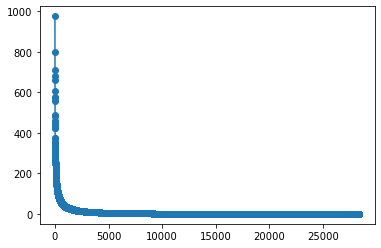

In [13]:
indice = np.argsort(-freq)
freq = freq[indice]
plt.plot(range(len(freq)),freq,marker ='o')

### Odds Ratio

['emmené', 'emparée', 'emmener', 'emmaüs', 'emma', 'emirats', 'emirat', 'emir', 'eminence', 'emilion', 'emile', 'emil', 'embûches', 'embuscades', 'emmenait', 'embuscade', 'empereur', 'empilement', 'employant', 'employait', 'emplois', 'emploieront', 'emploierez', 'emploierai', 'emploiera', 'emploient', 'emploie', 'emploi', 'emplissez', 'empereurs', 'emplir', 'emplacements', 'empiété', 'empiéter', 'empiétements', 'empiètements', 'empiète', 'empirique', 'empires', 'empire', 'empiler', 'empilent', 'empli', 'employeur', 'embryons', 'embryonnaire', 'embaucheront', 'embaucher', 'embauchent', 'embauche', 'embauchant', 'embauchait', 'embarrassé', 'embarras', 'embarquement', 'embarqua', 'embargos', 'embauches', 'embargo', 'elément', 'elysées', 'elysée', 'ely', 'elus', 'elu', 'elstir', 'eloigner', 'elles', 'elle', 'elita', 'embarcation', 'embryonnaires', 'embauchés', 'embellir', 'embryon', 'embryologie', 'embruns', 'embrigadement', 'embratel', 'embrasé', 'embrassons', 'embrasseraient', 'embrasser

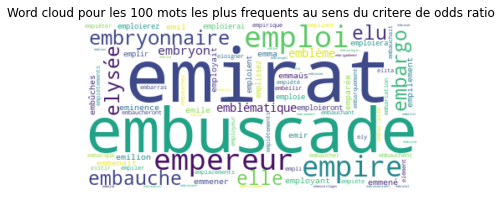

In [14]:
def get_Wordcloud_odds_ratio(X,labels_films):
    X_0 = X[np.where(labels_films == 0)[0]]
    X_1 = X[np.where(labels_films == 1)[0]]

    frequencies_0 = [np.sum(X_0[:,i]) for i in range(X_0.shape[1])]
    frequencies_1 = [np.sum(X_0[:,i]) for i in range(X_0.shape[1])]

    odds_ratio = [np.log((frequencies_0[i]*(1 - frequencies_1[i])) / (frequencies_1[i]*(1 - frequencies_0[i]))) for i in range(len(frequencies_0))]
    ind_freq = np.argsort(odds_ratio)[-100:]
    mots_freq3 = [vectorizer.get_feature_names_out()[i] for i in ind_freq]
    print(mots_freq3)

    w_cloud = ""
    for elem in mots_freq3:
        w_cloud += str(elem)+" " 

    wordcloud = WordCloud(background_color='White').generate(w_cloud)
    plt.imshow(wordcloud, interpolation='bilinear')
    plt.title("Word cloud pour les 100 mots les plus frequents au sens du critere de odds ratio")
    plt.axis("off")
    plt.show()
vectorizer = CountVectorizer()
X = vectorizer.fit_transform(data_large)
get_Wordcloud_odds_ratio(X,data_large)

# Binary BOW

les 100 mots les plus frequents dans le documents sont :
 ['plus' 'france' 'cette' 'aussi' 'pays' 'être' 'tout' 'tous' 'bien' 'nom'
 'comme' 'hui' 'aujourd' 'entre' 'doit' 'europe' 'monde' 'faire'
 'français' 'faut' 'si' 'sans' 'fait' 'date' 'cela' 'où' 'dire' 'ensemble'
 'peut' 'deux' 'développement' 'dont' 'très' 'leurs' 'encore' 'politique'
 'autres' 'président' 'monsieur' 'toutes' 'vie' 'ici' 'ceux' 'depuis'
 'temps' 'etat' 'toute' 'chacun' 'avenir' 'paix' 'union' 'européenne'
 'abord' 'notamment' 'ans' 'beaucoup' 'économique' 'toujours' 'elles'
 'sécurité' 'place' 'grande' 'histoire' 'là' 'cet' 'enfin' 'société'
 'devons' 'premier' 'grand' 'entreprises' 'parce' 'ainsi' 'autre' 'action'
 'fois' 'doivent' 'mieux' 'contre' 'hommes' 'chaque' 'travail' 'volonté'
 'déjà' 'également' 'droit' 'années' 'solidarité' 'dialogue' 'respect'
 'avoir' 'jeunes' 'alors' 'démocratie' 'coeur' 'moyens' 'souvent' 'donc'
 'république' 'confiance']


(-0.5, 399.5, 199.5, -0.5)

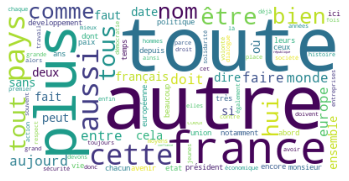

In [15]:
vectorizer = CountVectorizer(stop_words = final_stopwords_list,binary=True)
bow_binary = vectorizer.fit_transform(data_large) 
freq = bow_binary.sum(axis=0).A1
indice_100 = np.argsort(-freq)[:100]
mots_freq = np.array(vectorizer.get_feature_names_out())[indice_100]
print("les 100 mots les plus frequents dans le documents sont :\n", mots_freq)

corpus_100_freq =""
for mots in mots_freq : 
    corpus_100_freq += mots+" "
wordcoud_freq = WordCloud(background_color = "white",stopwords="").generate(corpus_100_freq)
plt.figure()
plt.imshow(wordcoud_freq)
plt.axis("off")

## Bigramme

In [16]:
vectorize  = TfidfVectorizer(ngram_range=(2,2))
X = vectorize.fit_transform(data_large)
freq = X.sum(axis=0).A1
indice = np.argsort(-freq)[:100]
print("les bigramme les plus frequent sont : \n", np.array(vectorize.get_feature_names_out())[indice])

les bigramme les plus frequent sont : 
 ['de la' 'la france' 'et de' 'aujourd hui' 'dans le' 'et la' 'il faut'
 'monsieur le' 'de notre' 'de nos' 'qu il' 'vous avez' 'tous les'
 'que nous' 'le président' 'dans la' 'et les' 'nous avons' 'il est'
 'est pas' 'est un' 'que la' 'est une' 'dans les' 'que vous' 'nous devons'
 'et des' 'pour la' 'qui est' 'et le' 'et je' 'que les' 'est la' 'ce que'
 'sur le' 'ce qui' 'le monde' 'de votre' 'que je' 'est le' 'doit être'
 'et messieurs' 'la paix' 'mesdames et' 'de cette' 'ceux qui' 'elle est'
 'de ce' 'du monde' 'qu elle' 'je suis' 'sur la' 'qui ont' 'pour les'
 'notre pays' 'par la' 'de ses' 'et qui' 'que le' 'je vous' 'les plus'
 'toutes les' 'est aussi' 'de tous' 'la vie' 'les français'
 'la république' 'je le' 'qu ils' 'je voudrais' 'de son' 'de ces'
 'union européenne' 'mesdames messieurs' 'par le' 'la sécurité' 'de leur'
 'sur les' 'nous sommes' 'mais aussi' 'je pense' 'plus de' 'la démocratie'
 'en date' 'je souhaite' 'le premier' 'parce q

## Trigramme

In [17]:
vectorize  = TfidfVectorizer(ngram_range=(3,3))
X = vectorize.fit_transform(data_large)
freq = X.sum(axis=0).A1
indice = np.argsort(-freq)[:100]
print("les trigramme les plus frequent sont : \n", np.array(vectorize.get_feature_names_out())[indice])

les trigramme les plus frequent sont : 
 ['monsieur le président' 'mesdames et messieurs' 'de la france' 'et de la'
 'la france est' 'de la république' 'dans le monde' 'ce est pas'
 'et la france' 'que vous avez' 'que la france' 'nos deux pays'
 'de plus en' 'plus en plus' 'de la vie' 'mes chers amis'
 'et messieurs les' 'de tous les' 'dans le domaine' 'au service de'
 'de la paix' 'la france et' 'monsieur le maire' 'de notre pays'
 'que nous avons' 'je suis heureux' 'de union européenne'
 'je souhaite que' 'dans le cadre' 'de la démocratie' 'ce qui est'
 'la lutte contre' 'est aujourd hui' 'je sais que' 'président de la'
 'vous le savez' 'droits de homme' 'la mise en' 'ne sont pas'
 'entre nos deux' 'le premier ministre' 'sur le plan' 'je vous remercie'
 'de la nation' 'au sein de' 'tous ceux qui' 'les moyens de' 'au coeur de'
 'plus que jamais' 'au nom de' 'le président de' 'qu il faut'
 'le respect de' 'de la communauté' 'tous les français' 'en même temps'
 'dans ce domaine' 'de la 

###   Performances attendrent  avantages et les inconvénients des ces variantes

- Pour le model binaire : bonne performance lorsque la presence d'un mot ou non est plus descriminante que la fréquence de ce mot, son principale inconvenient est qu'elle ne prend pas en copte la frequence du mot, par exemple un document qui contient un mot 50 fois va etre représenter de la meme maniere qu'un document qui en a q'un seul, alors qu'ils sont trés differents 
- Bi-gramme, tri-gramme : capture la relation sémantique entre les mots, mais l'incovénient est que si on avait beaucoup de dimension au début, cette derniere accroitera d'une maniere trés grande ce qui rends le model complex

- Réduire la taille du vocabulaire : l'avantage principale est qu'il permet de réduire la dimension du vocabulaire ce qui rends le model moins complex, cepandant, on peut éléminer des mots descriminant pour un document, donc une perte d'information trés importante
- TF-IDF : le plus grand avantage c'est qu'il detecte les mots les plus descriminant dans chaque document par rapport au corpus, cepandant, il peut attribuer des poids importants pour des mots rares qui n'ont pas de signification précise pour un genre de document

# C) Modèles de Machine Learning

## 1) Métriques d'évaluation 

Il faudra utiliser des métriques d'évaluation pertinentes suivant la tâche et l'équilibrage des données : 
- Accuracy
- Courbe ROC, AUC, F1-score

#### Création des vectorizer

In [18]:
liste_starts = [preprocess_strat1,preprocess_strat2,preprocess_strat3,preprocess_strat4,preprocess_strat5,preprocess_strat6]
liste_Cvectorizer = [CountVectorizer(stop_words=final_stopwords_list)]
                                    
for strat in liste_starts:
    liste_Cvectorizer.append(CountVectorizer(stop_words=final_stopwords_list, preprocessor = strat,max_df = 0.95, min_df = 4))

liste_Cvectorizer.append(CountVectorizer(stop_words=final_stopwords_list, preprocessor = preprocess_strat3, ngram_range = (2,2),max_features=10000))
liste_Cvectorizer.append(CountVectorizer(stop_words=final_stopwords_list, preprocessor = preprocess_strat1, ngram_range = (3,3),max_features= 10000))
# start3 for stemmed data
liste_Cvectorizer.append(CountVectorizer(stop_words=final_stopwords_list, preprocessor = preprocess_strat3,max_df = 0.95, min_df = 4))

####  TF-IDF

In [19]:
liste_TFvectorizer = [TfidfVectorizer(stop_words=final_stopwords_list)]
                                    
for strat in liste_starts:
    liste_TFvectorizer.append(TfidfVectorizer(stop_words=final_stopwords_list, preprocessor = strat,max_df = 0.95, min_df = 4))
# start3 for stemmed data
liste_TFvectorizer.append(TfidfVectorizer(stop_words=final_stopwords_list, preprocessor = preprocess_strat3,max_df = 0.95, min_df = 4))

#### Split 

In [21]:
# Split sur le data small
data_large_train,data_large_test,label_large_train,label_large_test = train_test_split(data_large,label_large, test_size=0.2)
# Le data large etant deja splité
data_large_train_stemmed = database_stemming(data_large_train)


100%|███████████████████████████████████████████████████████████████████████████| 45930/45930 [01:58<00:00, 387.34it/s]


#### fit vectorizer

In [45]:
liste_X_train_C = []
liste_score_C_lr_cout = []
liste_X_train_TF = []
for i, vect in tqdm(enumerate(liste_Cvectorizer[:3])):
    liste_X_train_C.append(vect.fit_transform(data_large_train))
    liste_X_train_TF.append(liste_TFvectorizer[i].fit_transform(data_large_train))  

for i, vect in tqdm(enumerate(liste_Cvectorizer[3:])):
    liste_X_train_C.append(vect.fit_transform(data_large_train_stemmed))
    
for i, vect in tqdm(enumerate(liste_TFvectorizer[3:])):
    liste_X_train_TF.append(vect.fit_transform(data_large_train_stemmed))

liste_X_test_C = []
liste_X_test_TF = []
for i, vect in tqdm(enumerate(liste_Cvectorizer)):
    liste_X_test_C.append(vect.transform(data_large_test))
    
for i, vect in tqdm(enumerate(liste_TFvectorizer)):
    liste_X_test_TF.append(vect.transform(data_large_test)) 


3it [00:24,  8.05s/it]
7it [00:33,  4.74s/it]
5it [00:20,  4.04s/it]
10it [00:11,  1.11s/it]
8it [00:08,  1.09s/it]


# Upsampling

In [47]:
liste_X_train_C_up = []
liste_Y_train_C_up = []
liste_score_C_ups = []
parameters = {'C': [0.001, 0.01, 0.1], 'penalty': ['l2']}

sm = SMOTE(sampling_strategy='minority')

for i,vect in tqdm(enumerate(liste_Cvectorizer[:3])):
    X = vect.fit_transform(data_large_train)
    x_train_smote,y_train_smote = sm.fit_resample(X, label_large_train)
    liste_X_train_C_up.append(x_train_smote)
    liste_Y_train_C_up.append(y_train_smote)
    
for vect in tqdm(liste_Cvectorizer[3:]):
    X = vect.fit_transform(data_large_train_stemmed)
    x_train_smote,y_train_smote = sm.fit_resample(X, label_large_train)
    liste_X_train_C_up.append(x_train_smote)
    liste_Y_train_C_up.append(y_train_smote)
    
liste_X_test_C_up = []
for vect in tqdm(liste_Cvectorizer):
    liste_X_test_C_up.append(vect.transform(data_large_test))
    
    
for i, X_train in tqdm(enumerate(liste_X_train_C_up)): 
    X_test = liste_X_test_C_up[i]
    lr = LogisticRegression(max_iter= 1000,penalty='l2')
    
    gridSCV = GridSearchCV(lr, parameters, cv=3,scoring=metrique_globale)
    gridSCV.fit(X_train,liste_Y_train_C_up[i])
    best_params = gridSCV.best_params_
    
    best_lr = LogisticRegression(**best_params, max_iter= 1000)
    best_lr.fit(X_train, liste_Y_train_C_up[i])
    y_pred = best_lr.predict(X_test)
    liste_score_C_ups.append((best_lr,accuracy_score(label_large_test,y_pred),f1_score(label_large_test,y_pred)))

3it [00:19,  6.44s/it]
100%|██████████████████████████████████████████████████████████████████████████████████| 10/10 [00:11<00:00,  1.14s/it]
10it [00:59,  5.94s/it]


In [48]:
print(liste_score_C_ups)

[(LogisticRegression(C=0.001, max_iter=1000), 0.6422537664373421, 0.7648809523809524), (LogisticRegression(C=0.001, max_iter=1000), 0.6371157363058434, 0.7611897529944408), (LogisticRegression(C=0.001, max_iter=1000), 0.6679439170948358, 0.7862787960316127), (LogisticRegression(C=0.001, max_iter=1000), 0.4834102586432117, 0.6076200555629051), (LogisticRegression(C=0.001, max_iter=1000), 0.484803622746669, 0.6083156779661018), (LogisticRegression(C=0.001, max_iter=1000), 0.4816685535138901, 0.6036755892928486), (LogisticRegression(C=0.001, max_iter=1000), 0.4823652355656187, 0.6051023119851182), (LogisticRegression(C=0.001, max_iter=1000), 0.3300531220064443, 0.3911357340720222), (LogisticRegression(C=0.001, max_iter=1000), 0.19872855525559524, 0.14480899711869133), (LogisticRegression(C=0.001, max_iter=1000), 0.48401985543847426, 0.6078496260506983)]


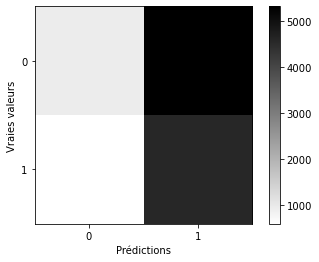

In [49]:
affiche_matrice_conf(y_pred,label_large_test)

# Undersampling

In [50]:
liste_X_train_C_und = []
liste_Y_train_C_und = []

liste_score_C_und = []
smote = SMOTE(sampling_strategy='majority')


for i,vect in tqdm(enumerate(liste_Cvectorizer[:3])):
    X = vect.fit_transform(data_large_train)
    x_train_smote,y_train_smote = sm.fit_resample(X, label_large_train)
    liste_X_train_C_und.append(x_train_smote)
    liste_Y_train_C_und.append(y_train_smote)
    
for vect in tqdm(liste_Cvectorizer[3:]):
    X = vect.fit_transform(data_large_train_stemmed)
    x_train_smote,y_train_smote = sm.fit_resample(X, label_large_train)
    liste_X_train_C_und.append(x_train_smote)
    liste_Y_train_C_und.append(y_train_smote)
    
liste_X_test_C_und = []

for vect in tqdm(liste_Cvectorizer):
    liste_X_test_C_und.append(vect.transform(data_large_test))
    
for i, X_train in tqdm(enumerate(liste_X_train_C_und)): 
    X_test = liste_X_test_C_und[i]
    lr = LogisticRegression(max_iter= 1000,penalty='l2')
    
    gridSCV = GridSearchCV(lr, parameters, cv=3,scoring=metrique_globale)
    gridSCV.fit(X_train,liste_Y_train_C_und[i])
    best_params = gridSCV.best_params_
    
    best_lr = LogisticRegression(**best_params, max_iter= 1000)
    best_lr.fit(X_train, liste_Y_train_C_und[i])
    y_pred = best_lr.predict(X_test)
    liste_score_C_und.append((best_lr,accuracy_score(label_large_test,y_pred),f1_score(label_large_test,y_pred)))

3it [00:19,  6.38s/it]
100%|██████████████████████████████████████████████████████████████████████████████████| 10/10 [00:11<00:00,  1.12s/it]
10it [00:57,  5.79s/it]


In [51]:
print(liste_score_C_und)

[(LogisticRegression(C=0.001, max_iter=1000), 0.6433858747714012, 0.7656115849121401), (LogisticRegression(C=0.001, max_iter=1000), 0.6376382478446398, 0.7614789337919174), (LogisticRegression(C=0.001, max_iter=1000), 0.6668118087607768, 0.7852733191155012), (LogisticRegression(C=0.001, max_iter=1000), 0.48358442915614386, 0.6077004498544588), (LogisticRegression(C=0.001, max_iter=1000), 0.4839327701820082, 0.607393666357493), (LogisticRegression(C=0.001, max_iter=1000), 0.48062353043629713, 0.6023469795972797), (LogisticRegression(C=0.001, max_iter=1000), 0.48088478620569536, 0.6030498768062863), (LogisticRegression(C=0.001, max_iter=1000), 0.32813724636419056, 0.38813545879927036), (LogisticRegression(C=0.001, max_iter=1000), 0.19890272576852738, 0.14515379611560264), (LogisticRegression(C=0.001, max_iter=1000), 0.4839327701820082, 0.6075496688741723)]


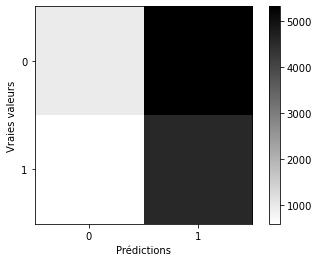

In [52]:
affiche_matrice_conf(y_pred,label_large_test)

# Modification de la fonction cout

In [53]:
def cout(y_true, y_pred, B=8):
    diff = np.abs(y_true - y_pred).sum()
    return {-1: diff * B , 1: diff}
cout_loss = make_scorer(lambda y_true, y_pred: cout(y_true, y_pred), greater_is_better=False)

## Lineaire SVM

In [54]:
liste_score_C_linsvm = []
parameters = {'C':[0.001,0.01, 0.1]}
for i, X_train in tqdm(enumerate(liste_X_train_C)): 
    X_test = liste_X_test_C[i]
    svc = LinearSVC()
    gridSCV = GridSearchCV(svc, parameters, cv=3, scoring=cout_loss)
    gridSCV.fit(X_train,label_large_train)
    best_svc = gridSCV.best_estimator_
    y_pred = best_svc.predict(X_test)
    liste_score_C_linsvm.append((best_svc,accuracy_score(label_large_test,y_pred),f1_score(label_large_test,y_pred)))

10it [00:20,  2.05s/it]


In [56]:
print(liste_score_C_linsvm)

[(LinearSVC(C=0.001), 0.8724200992771923, 0.9311268863711155), (LinearSVC(C=0.001), 0.8714621614560655, 0.9306260575296108), (LinearSVC(C=0.001), 0.873029696072455, 0.9314205079962371), (LinearSVC(C=0.001), 0.867717495428024, 0.9288024373095852), (LinearSVC(C=0.001), 0.867717495428024, 0.9288024373095852), (LinearSVC(C=0.001), 0.8683270922232866, 0.9290939786156444), (LinearSVC(C=0.001), 0.8682400069668205, 0.9290437555691038), (LinearSVC(C=0.001), 0.8634503178611861, 0.9267221235629498), (LinearSVC(C=0.001), 0.8634503178611861, 0.9267221235629498), (LinearSVC(C=0.001), 0.867717495428024, 0.9288024373095852)]


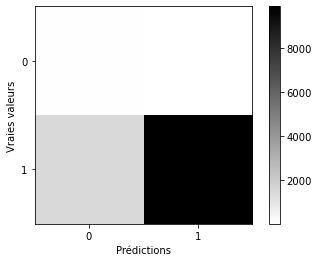

In [57]:
affiche_matrice_conf(y_pred,label_large_test)

## Regression Logistique

#### CountVectorizer

In [59]:
liste_score_C_lr_cout = []
for i, X_train in tqdm(enumerate(liste_X_train_C)): 
    hyperparameters = {'C': [0.001, 0.01, 0.1], 'penalty': ['l2']}
    X_test = liste_X_test_C[i]
    lr = LogisticRegression(max_iter=1000, class_weight='balanced')
    
    gridSCV = GridSearchCV(lr, hyperparameters, cv=3, scoring=cout_loss)
    gridSCV.fit(X_train, label_large_train)
    best_params = gridSCV.best_params_
    
    best_lr = LogisticRegression(**best_params, max_iter=1000, class_weight='balanced')
    best_lr.fit(X_train, label_large_train)
    y_pred = best_lr.predict(X_test)
    liste_score_C_lr_cout.append((best_lr, accuracy_score(label_large_test, y_pred), f1_score(label_large_test, y_pred)))

10it [00:40,  4.05s/it]


In [60]:
print(liste_score_C_lr_cout)

[(LogisticRegression(C=0.001, class_weight='balanced', max_iter=1000), 0.7772359139597667, 0.8624287404539099), (LogisticRegression(C=0.001, class_weight='balanced', max_iter=1000), 0.7757554645998432, 0.8611635304901063), (LogisticRegression(C=0.001, class_weight='balanced', max_iter=1000), 0.7832447966559262, 0.865771450142911), (LogisticRegression(C=0.001, class_weight='balanced', max_iter=1000), 0.8076286684664287, 0.8848939607107499), (LogisticRegression(C=0.001, class_weight='balanced', max_iter=1000), 0.8090220325698859, 0.8857990938915794), (LogisticRegression(C=0.001, class_weight='balanced', max_iter=1000), 0.8113733344944701, 0.8879461976202793), (LogisticRegression(C=0.001, class_weight='balanced', max_iter=1000), 0.8120700165461987, 0.888371611835299), (LogisticRegression(C=0.001, class_weight='balanced', max_iter=1000), 0.8398502133588783, 0.9088656524109222), (LogisticRegression(C=0.001, class_weight='balanced', max_iter=1000), 0.8564834973438997, 0.9221833978657098), (L

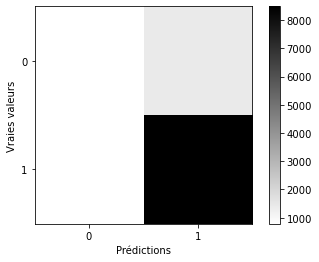

In [61]:
affiche_matrice_conf(y_pred,label_large_test)

#### IF -DF

In [62]:
liste_score_TF_lr_cout = []
for i, X_train in tqdm(enumerate(liste_X_train_TF)): 
    hyperparameters = {'C': [0.001, 0.01, 0.1], 'penalty': ['l2']}
    X_test = liste_X_test_TF[i]
    lr = LogisticRegression(max_iter=1000, class_weight='balanced')
    
    gridSCV = GridSearchCV(lr, hyperparameters, cv=3, scoring=cout_loss)
    gridSCV.fit(X_train, label_large_train)
    best_params = gridSCV.best_params_
    
    best_lr = LogisticRegression(**best_params, max_iter=1000, class_weight='balanced')
    best_lr.fit(X_train, label_large_train)
    y_pred = best_lr.predict(X_test)
    liste_score_TF_lr_cout.append((best_lr, accuracy_score(label_large_test, y_pred), f1_score(label_large_test, y_pred)))

8it [00:20,  2.55s/it]


In [63]:
print(liste_score_TF_lr_cout)

[(LogisticRegression(C=0.001, class_weight='balanced', max_iter=1000), 0.7774100844726988, 0.8612528498534362), (LogisticRegression(C=0.001, class_weight='balanced', max_iter=1000), 0.777671340242097, 0.8611670020120724), (LogisticRegression(C=0.001, class_weight='balanced', max_iter=1000), 0.7778455107550292, 0.8607912687585266), (LogisticRegression(C=0.001, class_weight='balanced', max_iter=1000), 0.8012714447444048, 0.8790929320758716), (LogisticRegression(C=0.001, class_weight='balanced', max_iter=1000), 0.8017939562832013, 0.8795257251746771), (LogisticRegression(C=0.001, class_weight='balanced', max_iter=1000), 0.8037969171819211, 0.881489663878807), (LogisticRegression(C=0.001, class_weight='balanced', max_iter=1000), 0.8039710876948533, 0.8815450192074935), (LogisticRegression(C=0.001, class_weight='balanced', max_iter=1000), 0.8012714447444048, 0.8790929320758716)]


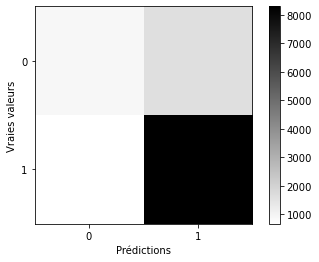

In [64]:
affiche_matrice_conf(y_pred,label_large_test)

## Arbre de decision

#### CountVectorizer

In [ ]:
liste_score_C_tree_cout = []
param_grid = {
    'max_depth': [5, 10, None],
    'min_samples_split': [2, 5]
}
for i, X_train in tqdm(enumerate(liste_X_train_C)): 
    X_test = liste_X_test_C[i]
    rfc = RandomForestClassifier()
    gridSCV = GridSearchCV(rfc, param_grid, cv=2, scoring=cout_loss)
    gridSCV.fit(X_train, label_large_train)
    best_rfc = gridSCV.best_estimator_
    y_pred = best_rfc.predict(X_test)
    liste_score_C_tree_cout.append((best_lr, accuracy_score(label_large_test, y_pred), f1_score(label_large_test, y_pred)))"

In [ ]:
print(liste_score_C_tree)

#### TF-IDF

In [ ]:
liste_score_TF_tree_cout = []
param_grid = {
    'max_depth': [5, 10, 13, None],
    'min_samples_split': [2, 5, 10]
}

for i, X_train in tqdm(enumerate(liste_X_train_TF)):
    X_test = liste_X_test_TF[i]
    rfc = RandomForestClassifier()
    gridSCV = GridSearchCV(rfc, param_grid, cv=2, scoring=cout_loss)
    gridSCV.fit(X_train, label_large_train)
    best_rfc = gridSCV.best_estimator_
    y_pred = best_rfc.predict(X_test)
    liste_score_TF_tree_cout.append((best_lr, accuracy_score(label_large_test, y_pred), f1_score(label_large_test, y_pred)))

In [ ]:
print(liste_score_TF_tree_cout)

## Naive Bayes

#### CountVectorizer

In [67]:
liste_score_C_nb_cout = []
param_grid = {
    'alpha': [0.1, 0.5, 1, 2],
    'fit_prior': [True, False]
}

for i, X_train in tqdm(enumerate(liste_X_train_C)):
    X_test = liste_X_test_C[i]
    nb = MultinomialNB()
    grid_search = GridSearchCV(nb, param_grid, cv=2, scoring=cout_loss)
    grid_search.fit(X_train, label_large_train)
    best_nb = grid_search.best_estimator_
    best_nb.fit(X_train, label_large_train)
    y_pred = best_nb.predict(X_test)
    liste_score_C_nb_cout.append((best_nb, accuracy_score(label_large_test, y_pred), f1_score(label_large_test, y_pred)))

10it [00:03,  2.76it/s]


In [68]:
print(liste_score_C_nb_cout)

[(MultinomialNB(alpha=0.1), 0.8925367935208569, 0.9387714597598492), (MultinomialNB(alpha=0.1), 0.8886179569798833, 0.936428251901188), (MultinomialNB(alpha=0.1), 0.8931463903161195, 0.9388913790527416), (MultinomialNB(alpha=0.1), 0.8799094313332753, 0.9310534473276336), (MultinomialNB(alpha=0.1), 0.8790385787686145, 0.9304839597617736), (MultinomialNB(alpha=0.1), 0.8799965165897413, 0.9310862172434488), (MultinomialNB(alpha=0.1), 0.8795610903074109, 0.9308396259438916), (MultinomialNB(alpha=0.1), 0.8727684403030567, 0.9302258942642916), (MultinomialNB(alpha=0.1), 0.8644082556823129, 0.9270350063264445), (MultinomialNB(alpha=0.1), 0.8799094313332753, 0.9310534473276336)]


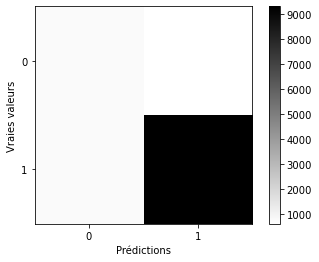

In [69]:
affiche_matrice_conf(y_pred,label_large_test)

#### IF-IDF 

In [70]:
liste_score_TF_nb_cout = []
param_grid = {
    'alpha': [0.1, 0.5, 1, 2],
    'fit_prior': [True, False]
}

for i,X_train in tqdm(enumerate(liste_X_train_TF)):
    X_test = liste_X_test_TF[i]
    nb = MultinomialNB()
    grid_search = GridSearchCV(nb, param_grid, cv=2, scoring=cout_loss)
    grid_search.fit(X_train, label_large_train)
    best_nb = grid_search.best_estimator_
    best_nb.fit(X_train, label_large_train)
    y_pred = best_nb.predict(X_test)
    liste_score_TF_nb_cout.append((best_nb, accuracy_score(label_large_test, y_pred), f1_score(label_large_test, y_pred)))


8it [00:03,  2.51it/s]


In [71]:
print(liste_score_TF_nb_cout)

[(MultinomialNB(alpha=0.1), 0.8821736480013934, 0.9357519350396506), (MultinomialNB(alpha=0.1), 0.8799965165897413, 0.934747608675064), (MultinomialNB(alpha=0.1), 0.8845249499259775, 0.9370430158579433), (MultinomialNB(alpha=0.1), 0.8822607332578595, 0.9357536590001901), (MultinomialNB(alpha=0.1), 0.8827832447966559, 0.9360266159695818), (MultinomialNB(alpha=0.1), 0.8826961595401899, 0.9359638697409081), (MultinomialNB(alpha=0.1), 0.8825219890272576, 0.9358809829364515), (MultinomialNB(alpha=0.1), 0.8822607332578595, 0.9357536590001901)]


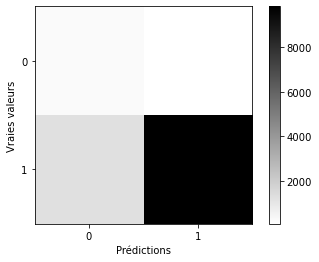

In [72]:
affiche_matrice_conf(y_pred,label_large_test)

## Xgboost

In [ ]:
import xgboost as xgb

x_train = liste_Cvectorizer[2].transform(data_large_train)

x_test = liste_Cvectorizer[2].transform(data_large_test)


dtrain = xgb.DMatrix(x_train, label=label_large_train)
dtest = xgb.DMatrix(x_test, label=label_large_test)
# Définition des hyperparamètres du modèle
params = {
    'max_depth': 3, 
    'eta': 0.1, 
    'objective': 'binary:logistic', 
    'eval_metric': 'logloss'
}

# Entraînement du modèle
num_rounds = 100
xgb_model = xgb.train(params, dtrain, num_rounds)

# Prédiction sur l'ensemble de test
y_proba = xgb_model.predict(dtest)
y_pred = np.where(y_proba > 0.5 , 1, -1)

# Courbe ROC et modification du biais

In [79]:
def trouve_optimal_bias(model, X, y, bias_range):
    y_prob = model.predict_proba(X)[:,1]
    fpr, tpr, thresholds = roc_curve(y, y_prob, pos_label=1)
    roc_auc = auc(fpr, tpr)
    plt.plot(fpr, tpr, color='darkorange', lw=2, label='ROC curve (AUC = %0.2f)' % roc_auc)
    plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('Courbe ROC avant ajustement')
    plt.legend(loc="lower right")
    plt.show()
    
    optimal_bias = None
    max_f1_score = 0

    for bias in bias_range:
        y_pred = np.where(y_prob + bias > 0.5, 1, -1)
        cm = confusion_matrix(y, y_pred,labels=[-1, 1])
        tn, fp, fn, tp = cm[0][0],cm[0][1],cm[1][0],cm[1][1]
        precision = tp / (tp + fp)
        recall = tp / (tp + fn)
        f1_score = 2 * (precision * recall) / (precision + recall)
        if f1_score > max_f1_score:
            max_f1_score = f1_score
            optimal_bias = bias
        
    return optimal_bias

def adjuste_predictions(model, X, bias):
    y_before = model.predict(X)
    y_prob = model.predict_proba(X)[:,1]
    
    y_pred = np.where(y_prob + bias > 0.5, 1, -1)
    return y_pred

F1-Score Avant ajustement :  0.9388913790527416


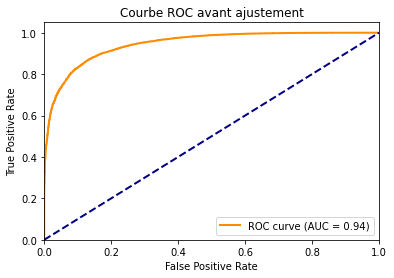

F1 - Score aprés ajustement  :  0.946190522526029


In [84]:
y_train_opt = label_large_train
model = liste_score_C_nb_cout[2][0]
bias_range = np.linspace(-1, 1, 21)
print("F1-Score Avant ajustement : ",liste_score_C_nb_cout[2][2])

x_train = liste_Cvectorizer[2].transform(data_large_train)
model.fit(x_train,y_train_opt)
optimal_biais = trouve_optimal_bias(model,x_train,y_train_opt,bias_range)

x_test = liste_Cvectorizer[2].transform(data_large_test)
y_train_opt = adjuste_predictions(model,x_test,optimal_biais)
print("F1 - Score aprés ajustement  : ",f1_score(y_train_opt,label_large_test))

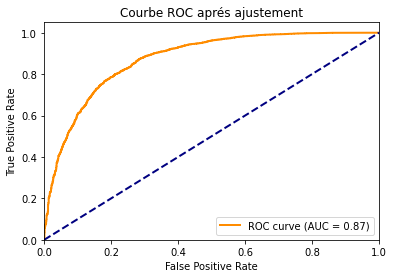

In [85]:
y_prob = model.predict_proba(x_test)[:,1]
fpr, tpr, thresholds = roc_curve(label_large_test, y_prob, pos_label=1)
roc_auc = auc(fpr, tpr)
plt.plot(fpr, tpr, color='darkorange', lw=2, label='ROC curve (AUC = %0.2f)' % roc_auc)
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Courbe ROC aprés ajustement')
plt.legend(loc="lower right")
plt.show()

## 2) Variantes sur les stratégies d'entraînement

- **Sur-apprentissage**. Les techniques sur lesquelles nous travaillons étant sujettes au sur-apprentissage: trouver le paramètre de régularisation dans la documentation et optimiser ce paramètre au sens de la métrique qui vous semble la plus appropriée (cf question précédente).

 <br>
- **Equilibrage des données**. Un problème reconnu comme dur dans la communauté est celui de l'équilibrage des classes (*balance* en anglais). Que faire si les données sont à 80, 90 ou 99% dans une des classes?
Le problème est dur mais fréquent; les solutions sont multiples mais on peut isoler 3 grandes familles de solution.

1. Ré-équilibrer le jeu de données: supprimer des données dans la classe majoritaire et/ou sur-échantilloner la classe minoritaire.<BR>
   $\Rightarrow$ A vous de jouer pour cette technique
1. Changer la formulation de la fonction de coût pour pénaliser plus les erreurs dans la classe minoritaire:
soit une fonction $\Delta$ mesurant les écarts entre $f(x_i)$ et $y_i$ 
$$C = \sum_i  \alpha_i \Delta(f(x_i),y_i), \qquad \alpha_i = \left\{
\begin{array}{ll}
1 & \text{si } y_i \in \text{classe majoritaire}\\
B>1 & \text{si } y_i \in \text{classe minoritaire}\\
\end{array} \right.$$
<BR>
   $\Rightarrow$ Les SVM et d'autres approches sklearn possèdent des arguments pour régler $B$ ou $1/B$... Ces arguments sont utiles mais pas toujours suffisant.
1. Courbe ROC et modification du biais. Une fois la fonction $\hat y = f(x)$ apprise, il est possible de la *bidouiller* a posteriori: si toutes les prédictions $\hat y$ sont dans une classe, on va introduire $b$ dans $\hat y = f(x) + b$ et le faire varier jusqu'à ce qu'un des points change de classe. On peut ensuite aller de plus en plus loin.
Le calcul de l'ensemble des scores associés à cette approche mène directement à la courbe ROC.

**Note:** certains classifieurs sont intrinsèquement plus résistante au problème d'équilibrage, c'est par exemple le cas des techniques de gradient boosting que vous verrez l'an prochain.

### Equilibrage des données

- Pour commencer, Nous avons afficher les proportions de chaque classe, nous avons constater qu'il y a un grand désiquilibre entre les classes, pour remedier à cela, nous avons programmé les 3 approches proposés dans ce projet 


## 3) Estimer les performances de généralisation d'une méthodes
**Ce sera l'enjeu principal du projet : vous disposez d'un ensemble de données, et vous évaluerez les performances sur un ensemble de test auquel vous n'avez pas accès. Il faut donc être capable d'estimer les performances de généralisation du modèles à partir des données d'entraînement.**


Avant de lancer de grandes expériences, il faut se construire une base de travail solide en étudiant les questions suivantes:

- Combien de temps ça prend d'apprendre un classifieur NB/SVM/RegLog sur ces données en fonction de la taille du vocabulaire?
- La validation croisée est-elle nécessaire? Est ce qu'on obtient les mêmes résultats avec un simple *split*?
- La validation croisée est-elle stable? A partir de combien de fold (travailler avec différentes graines aléatoires et faire des statistiques basiques)?

#### Temps d'execution

- A part l'arbre de décision, tout les autres modèles sont rapide en execution danc cette ensemble de donnée, cela est du au fait que le vocabulaire est plus petit que celui du projet précédent

#### Validation Croisée 

- La validation croisée est recommandée pour éviter le surajustement du modèle et pour obtenir une estimation plus fiable de ses performances. elle est donc nécessaire pour obtenir une estimation précise des performances du modèle.

 #### simple split

- Un simple split peut être utilisé pour évaluer les performances d'un modèle, mais il est  considéré comme moins fiable que la validation croisée. parce que les performances du modèle peuvent varier en fonction de la manière dont les données sont divisées en ensembles d'entraînement et de test

#### Extraire le model le plus performant

In [86]:
f = open("./datasets/AFDpresidentutf8/test_eval_pres.txt","r", encoding="utf-8").read()
x_eval = np.array(f.split("\n")[:-1])
x = liste_Cvectorizer[2].transform(x_eval)
model = liste_score_C_nb_cout[2][0]
y_pred = model.predict(x)
create_output_file(y_pred,name = "nb_cout_pres")